#  Plot Ligands/Receptors between Immune - Endo

In [1]:
library(dplyr)
library(reshape2)
library(plyr)
library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)

get_cells2genes = function(genes2filter = NULL){
    # Merge as data frame for plotting with ggplot
    cells2genesCP = subset(PERC, Gene %in% genes2plot)
    # transfer expression info     
    cells2genesCP$cell = cells2genesCP$L1
    cells2genesCP$gene = cells2genesCP$Gene
    cells2genesCP$id = paste(cells2genesCP$cell, cells2genesCP$gene)
    return(cells2genesCP)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




In [2]:
# get_cells2genes = function(genes2filter = NULL){
#     genes2filter = genes2plot
#     # Merge as data frame for plotting with ggplot
#     cells2genesCP = subset(PERC, Gene %in% genes2plot)
#     return(cells2genesCP)
# }

# Load Cellphone Genes

In [3]:
# Define variables
filter_int_user_curated = T #Use only user_curated interactions?
per_cutoff = 0.1 # min % of cells in the cluster required  with expression > 0 for the gene
pval_cutoff = 0.001 # max adjusted p-value requeired to consider a gene as DEG
logFC_cutoff = 0 # min logFC to consider a gene as DEG

In [4]:
# Load cellphone database - genes and complexes file
# Gene names
genes_cpDB = read.delim('~/cellphoneDB/hsa_uniprot.txt', stringsAsFactors = F, sep = '\t')

# Complexes members
com_cpDB = read.csv('~/farm/CellPhoneDB-data_smallmolecules/data/sources/complex_curated.csv', stringsAsFactors = F)
com_cpDB = unique(com_cpDB)
com_cpDB$complex_name = paste0('complex:', com_cpDB$complex_name)
# Generate complexes2gene symbol dictionary
Com2Gene = lapply(com_cpDB$complex_name, function(cx) subset(genes_cpDB, uniprot %in% unlist(com_cpDB[com_cpDB$complex_name == cx, 2:5]) )$gene_name )
Com2Gene = lapply(Com2Gene, unique)
names(Com2Gene) = com_cpDB$complex_name
                  
# Load interactions from cellphoneDB/out/means.txt output file                   
int_cpDB = read.delim('data/cellphoneDB_endothelial/out/means.txt', stringsAsFactors = F)[, 1:10]
# MANDATORY: remove "curated" because we have cleaned and renamed them (this is a long story, just do it)
int_cpDB = subset(int_cpDB, annotation_strategy != 'curated')
# OPTIONAL: Use only user_curated interactions?
if(filter_int_user_curated)
    int_cpDB = subset(int_cpDB, annotation_strategy == 'user_curated')
# Generate Int2Gene dictionary
Int2Gene = apply(int_cpDB, 1, function(int) {
    int = unname(int)
    if(int[5] == '') # if partnerA is complex, then retrieve members from dictionary
       partnerA = Com2Gene[[int[3]]]
    else  # if partnerA is a single gene, take name from file
       partnerA = int[5]
    if(int[6] == '')  # if partnerB is complex, then retrieve members from dictionary
       partnerB = Com2Gene[[int[4]]]
    else  # if partnerB is a single gene, take name from file
       partnerB = int[6]
    list(partner_a=partnerA,partner_b=partnerB)
    }) 
names(Int2Gene) = int_cpDB$interacting_pair

# Load expression information

### % Expr

In [5]:
# Load percentage expression info
# you need to put in a folder a file for each cluster that you included in cellphone
# The file must contain at least three columns (aka, you can reuse the output of the DEG files):
# - Gene: gene symbol
# - cluster: cell type
# - percentExpr_cluster: % of cells in the cluster with expression > 0 for the gene
# path_Exp = '/home/jovyan/farm/endometrium/data/cellphoneDB/clusterDEGs_and_TFs/DEGs/'
path_Exp = '/home/jovyan/farm/endometrium/figures_primaryall/cluster_markers/'


# Load
Per_files = list.files(path_Exp, pattern = '_DEGs.csv', full.names = T) %>% 
    grep('scanpy', ., value = T, invert = T)  %>% 
    grep('vs', ., value = T, invert = T)
Per_names = list.files(path_Exp, pattern = '_DEGs.csv') %>% 
    grep('scanpy', ., value = T, invert = T) %>% 
    grep('vs', ., value = T, invert = T)
Per_df = lapply(Per_files, read.csv, stringsAsFactors = F) 

# Set rownames as genes, for convenience
Per_df = lapply(Per_df, function(x){ 
    rownames(x) = x$Gene
    return(x) })

# Remove genes not in cellphone or not expressed
Per_df = lapply(Per_df, function(x) subset(x, Gene %in% genes_cpDB$gene_name & percentExpr_cluster > per_cutoff))

                
# Build dictionary clusters2expressed genes                       
names(Per_df) = gsub('_DEGs.csv', '', Per_names)
                                              
PERC = melt(Per_df, id.vars = names(Per_df[[1]]))
PERC$id = paste(PERC$cluster, PERC$Gene)                      
head(PERC)
                      

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,endo_arterial,CLDN5,2.2303206,0,0,2.53,0.30,0.93,0.16,endo_arterial,endo_arterial CLDN5
2,endo_arterial,CLEC14A,1.7017444,0,0,1.92,0.21,0.93,0.13,endo_arterial,endo_arterial CLEC14A
3,endo_arterial,NOTCH4,0.9931673,0,0,1.08,0.09,0.77,0.09,endo_arterial,endo_arterial NOTCH4
4,endo_arterial,ICAM2,1.2014195,0,0,1.35,0.15,0.84,0.13,endo_arterial,endo_arterial ICAM2
5,endo_arterial,RAMP2,2.0385570,0,0,2.43,0.39,0.95,0.26,endo_arterial,endo_arterial RAMP2
6,endo_arterial,PECAM1,1.4628345,0,0,1.69,0.23,0.92,0.15,endo_arterial,endo_arterial PECAM1


# Immune/PV crosstalk 

Left Receptors: columns (endo_venular; endo_arterial; endo_lymphatic) & rows (CCL14; CCL1)

Right Ligands: columns (macrophages; NK cells; T cells) & rows (CCR1; CCR7)

## Receptors

 Receptors: CCR1; CCR7



#### Load genes of interest

In [6]:
genes2plot = c('CCR1', 'CCR7')
genes2plot

[1] "CCR1" "CCR7"

#### Generate cells2genes in cellphone for interactions containing genes of interest

In [7]:
cells2genes = get_cells2genes(genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id,cell,gene
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
49212,myeloid,CCR1,0.4436813,0.00000e+00,0.000000e+00,0.46,0.01,0.42,0.01,myeloid,myeloid CCR1,myeloid,CCR1
55535,NK,CCR1,0.1219378,2.21078e-120,1.226519e-118,0.14,0.02,0.14,0.02,NK,NK CCR1,NK,CCR1
69449,T_cells,CCR7,0.2994251,0.00000e+00,0.000000e+00,0.30,0.01,0.21,0.00,T_cells,T_cells CCR7,T_cells,CCR7


In [8]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
unique(sort(df$gene))

[1] "CCR1" "CCR7"

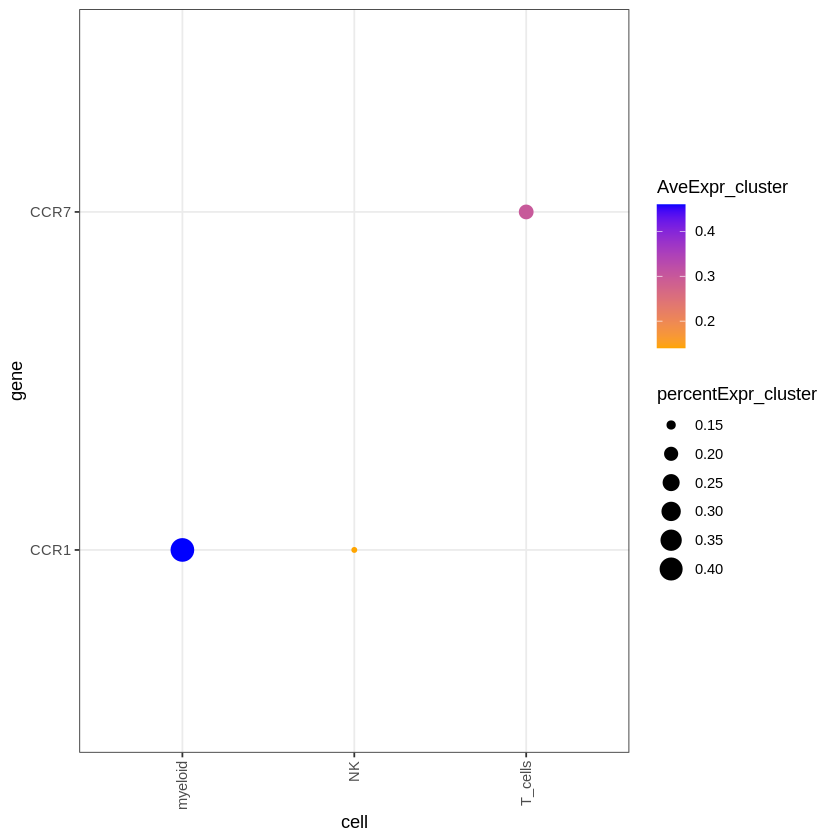

In [9]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# subset
df = subset(df, cell %in% c('T_cells', 'myeloid', 'NK') )

ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB/clusterDEGs_and_TFs/L_and_R_plots/Figure1F_dotplotLigands.pdf', dpi = 300, width = 4, height = 3.8)

## Ligands

Ligands; CCL14, CCL1


#### Load genes of interest

In [10]:
genes2plot = c('CCL14','CCL21')
genes2plot

[1] "CCL14" "CCL21"

#### Generate cells2genes in cellphone for interactions containing genes of interest

In [11]:
cells2genes = get_cells2genes(genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id,cell,gene
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1090,endo_arterial,CCL14,0.18500484,1.120710e-57,2.135381e-56,0.32,0.14,0.28,0.09,endo_arterial,endo_arterial CCL14,endo_arterial,CCL14
7270,endo_lymphatic,CCL21,4.38871757,0.000000e+00,0.000000e+00,4.43,0.04,0.99,0.03,endo_lymphatic,endo_lymphatic CCL21,endo_lymphatic,CCL21
12343,endo_lymphatic,CCL14,0.01493839,7.605513e-01,9.645782e-01,0.17,0.16,0.15,0.11,endo_lymphatic,endo_lymphatic CCL14,endo_lymphatic,CCL14
12878,endo_velular,CCL14,1.10070281,0.000000e+00,0.000000e+00,1.15,0.05,0.72,0.04,endo_velular,endo_velular CCL14,endo_velular,CCL14
65058,PV_STEAP4,CCL21,0.16479317,4.584921e-57,2.203217e-55,0.21,0.05,0.11,0.02,PV_STEAP4,PV_STEAP4 CCL21,PV_STEAP4,CCL21


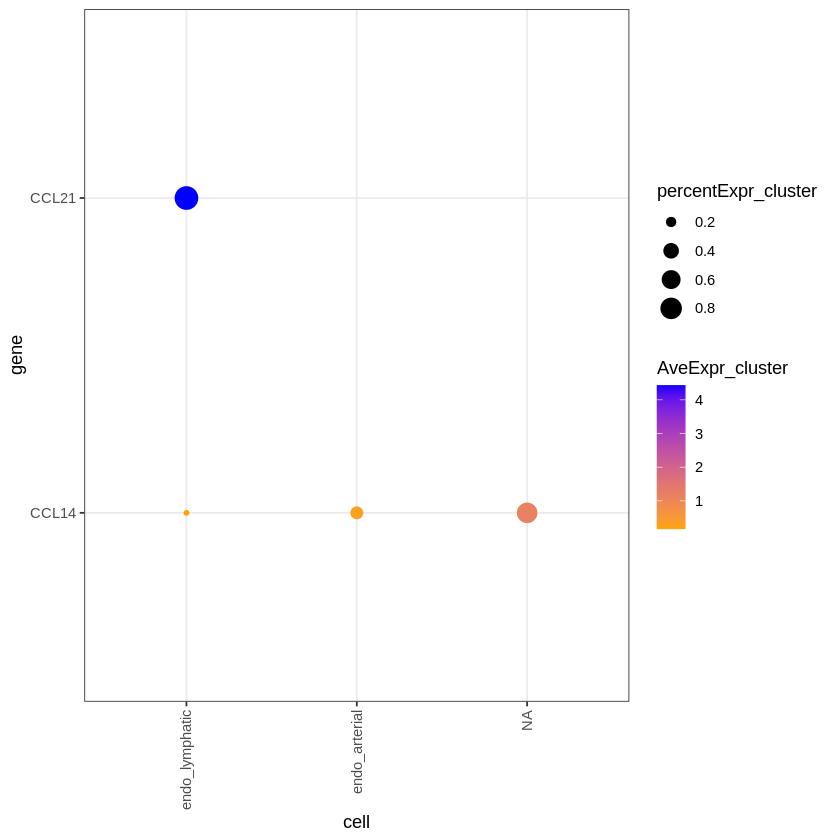

In [12]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# filter epi
df = df[ grep('endo', df$cell) ,]
df$cell = gsub('_scanpy', '', df$cell)
# ordre endo_venular; endo_arterial; endo_lymphatic
df$cell = factor(df$cell, levels = rev(c('endo_venular', 'endo_arterial', 'endo_lymphatic') ))
ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster), ) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

ggsave(filename = 'data/cellphoneDB/clusterDEGs_and_TFs/L_and_R_plots/Figure1F_dotplotReceptors.pdf', dpi = 300, width = 4, height = 3.8)